<a href="https://colab.research.google.com/github/siyapareek/Assignment-/blob/main/eCommerce_Transactions_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/Colab_Datasets')

In [3]:
#libraries whihc are neccessary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score


pd.set_option('display.max_columns', None)

In [4]:
# Loading the  datasets
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")


print("Customers Dataset:")
display(customers.head())

print("\nProducts Dataset:")
display(products.head())

print("\nTransactions Dataset:")
display(transactions.head())


Customers Dataset:


,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15



Products Dataset:


,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.30
1,P002,ActiveWear Smartwatch,Electronics,346.30
2,P003,ComfortLiving Biography,Books,44.12
3,P004,BookWorld Rug,Home Decor,95.69
4,P005,TechPro T-Shirt,Clothing,429.31



Transactions Dataset:


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [5]:
# Check for missing values
print("Missing values in Customers:")
print(customers.isnull().sum())

print("\nMissing values in Products:")
print(products.isnull().sum())

print("\nMissing values in Transactions:")
print(transactions.isnull().sum())

# Checking duplicates
print("\nDuplicates in Customers:", customers.duplicated().sum())
print("Duplicates in Products:", products.duplicated().sum())
print("Duplicates in Transactions:", transactions.duplicated().sum())


Missing values in Customers:
CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64

Missing values in Products:
ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64

Missing values in Transactions:
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64

Duplicates in Customers: 0
Duplicates in Products: 0
Duplicates in Transactions: 0


In [6]:

customers.dropna(inplace=True)
products.dropna(inplace=True)
transactions.dropna(inplace=True)


<ipython-input-7-d0aeae45ceb6>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=customers, x='Region', palette='viridis')


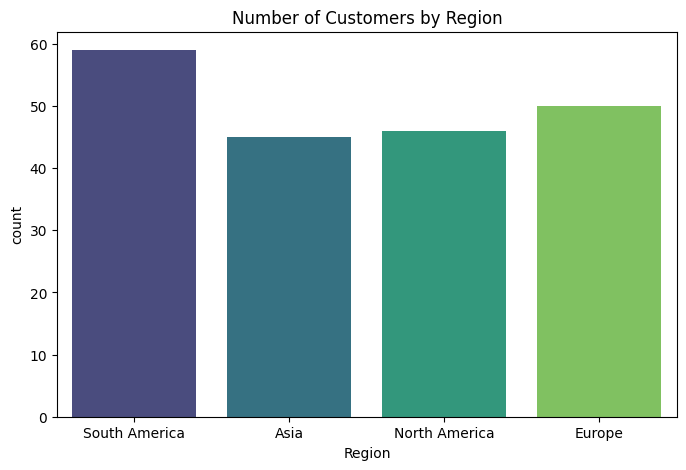

In [7]:
plt.figure(figsize=(8, 5))
sns.countplot(data=customers, x='Region', palette='viridis')
plt.title('Number of Customers by Region')
plt.show()


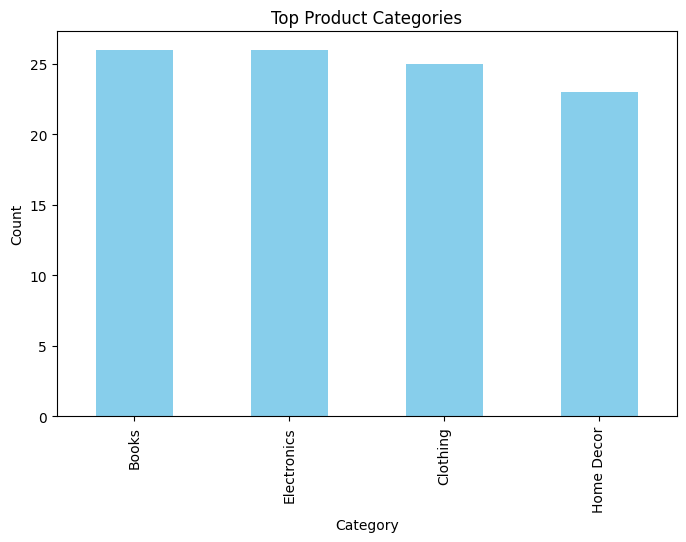

In [8]:
plt.figure(figsize=(8, 5))
products['Category'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Top Product Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()


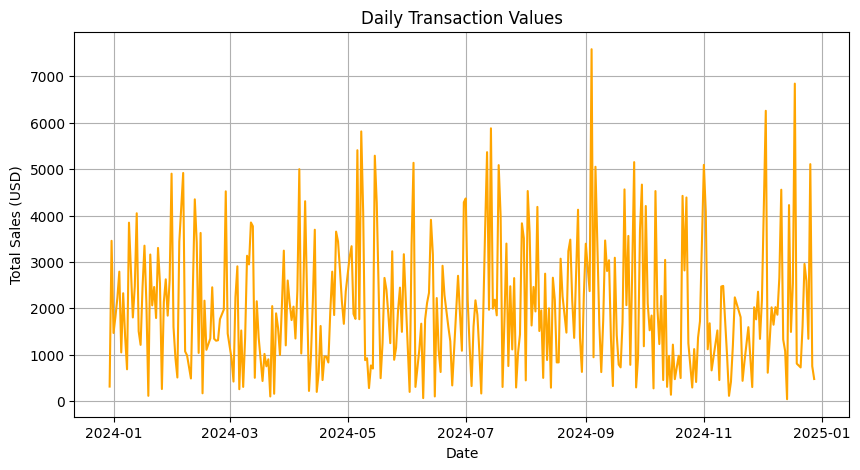

In [9]:

transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])


daily_sales = transactions.groupby(transactions['TransactionDate'].dt.date)['TotalValue'].sum()

plt.figure(figsize=(10, 5))
daily_sales.plot(title='Daily Transaction Values', color='orange')
plt.xlabel('Date')
plt.ylabel('Total Sales (USD)')
plt.grid(True)
plt.show()


In [10]:

data = pd.merge(transactions, customers, on='CustomerID')
data = pd.merge(data, products, on='ProductID')


print("Merged Dataset:")
display(data.head())


Merged Dataset:


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics,300.68


In [13]:
from sklearn.preprocessing import StandardScaler, LabelEncoder


customer_features = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total transaction value
    'Quantity': 'sum',    # Total quantity purchased
    'Category': lambda x: x.mode()[0]  # Most common product category
}).reset_index()


encoder = LabelEncoder()
customer_features['Category'] = encoder.fit_transform(customer_features['Category'])


scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[['TotalValue', 'Quantity', 'Category']])


from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(scaled_features)


lookalikes = {}
for i, customer in enumerate(customer_features['CustomerID']):
    similar_customers = sorted(
        list(enumerate(similarity_matrix[i])),
        key=lambda x: -x[1]
    )[1:4]
    lookalikes[customer] = [
        (customer_features['CustomerID'][j], round(score, 2)) for j, score in similar_customers
    ]


for customer, similar in list(lookalikes.items())[:5]:
    print(f"Customer {customer} Lookalikes: {similar}")


Customer C0001 Lookalikes: [('C0164', 1.0), ('C0152', 0.99), ('C0026', 0.99)]
Customer C0002 Lookalikes: [('C0029', 1.0), ('C0088', 1.0), ('C0144', 0.99)]
Customer C0003 Lookalikes: [('C0160', 1.0), ('C0086', 0.99), ('C0038', 0.99)]
Customer C0004 Lookalikes: [('C0175', 0.99), ('C0017', 0.99), ('C0075', 0.99)]
Customer C0005 Lookalikes: [('C0097', 1.0), ('C0186', 1.0), ('C0192', 1.0)]


In [14]:
# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Adding cluster labels to customer features
customer_features['Cluster'] = clusters

db_index = davies_bouldin_score(scaled_features, clusters)
print(f"Davies-Bouldin Index: {db_index}")


Davies-Bouldin Index: 0.9560478221164392


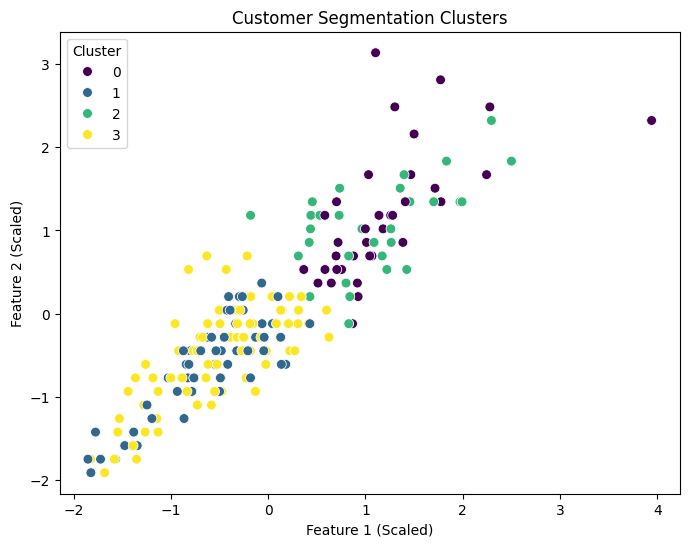

In [15]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=scaled_features[:, 0],
    y=scaled_features[:, 1],
    hue=clusters,
    palette='viridis',
    s=50
)
plt.title('Customer Segmentation Clusters')
plt.xlabel('Feature 1 (Scaled)')
plt.ylabel('Feature 2 (Scaled)')
plt.legend(title='Cluster')
plt.show()


In [16]:

lookalike_df = pd.DataFrame([
    {'CustomerID': customer, 'Lookalikes': similar}
    for customer, similar in lookalikes.items()
])
lookalike_df.to_csv('Lookalikes.csv', index=False)
